In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
import torch
from torch import nn
import torch.nn.functional as F

In [76]:
# Input img -> hidden dim -> mean, std -> parametrization
# -> decoder -> output img

class VAEModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.common_fc = nn.Sequential(
            nn.Linear(28*28, 196),
            nn.Tanh(),
            nn.Linear(196, 48),
            nn.Tanh(),
        )

        self.mean_fc = nn.Sequential(
            nn.Linear(48, 16),
            nn.Tanh(),
            nn.Linear(16, 2),
        )

        self.log_var_fc = nn.Sequential(
            nn.Linear(48, 16),
            nn.Tanh(),
            nn.Linear(16, 2)
        )

        self.decoder_fcs = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16, 48),
            nn.Tanh(),
            nn.Linear(48, 196),
            nn.Tanh(),
            nn.Linear(196, 28*28),
        )

    def forward(self, x):
        # B, C, H, W
        # Encoder part
        mean, log_var = self.encode(x)

        # Sampling
        z = self.sample(mean, log_var)

        # Decoder part
        out = self.decode(z)

        return mean, log_var, out

    def encode(self, x):
        out = self.common_fc(torch.flatten(x, start_dim=1))
        mean = self.mean_fc(out)
        log_var = self.log_var_fc(out)

        return mean, log_var
    
    def sample(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std)
        z = z * std + mean

        return z
    
    def decode(self, z):
        out = self.decoder_fcs(z)
        out = out.reshape((z.size(0), 1, 28, 28))

        return out

In [11]:
import torchvision.datasets as datasets
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 784
h_dim = 200
z_dim = 2
num_epochs = 10
batch_size = 64
lr_rate = 1e-3

In [105]:
dataset = datasets.MNIST(root="dataset/",
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True)

model = VAEModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
loss_fn = nn.MSELoss()

In [110]:
def train_vae():
    kl_losses = []
    recon_losses = []
    losses = []
    for epoch in range(num_epochs):
        for i, (x, y) in tqdm(
            enumerate(train_loader),
            desc=f"Epoch {epoch+1}",
            total=len(train_loader)):

            x = x.to(device)

            x = 2*x-1

            flat_x = x.to(device).view(x.shape[0], input_dim)
            # print(flat_x.shape)
            mean, log_var, out = model(flat_x)

            # Loss
            kl_loss = torch.mean(0.5 * torch.sum(torch.exp(log_var) + mean**2 - 1 - log_var, dim=-1))
            recon_loss = loss_fn(out, x)
            loss = recon_loss + 0.00001 * kl_loss
            
            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Loss: {np.mean(losses):.4f} | MSE: {np.mean(recon_losses):.4f} | KL: {np.mean(kl_losses):.4f}")

In [111]:
train_vae()

Epoch 1: 100%|██████████| 938/938 [00:08<00:00, 104.41it/s]


Loss: 0.2542 | MSE: 0.2541 | KL: 3.5734


Epoch 2: 100%|██████████| 938/938 [00:08<00:00, 105.40it/s]


Loss: 0.2266 | MSE: 0.2265 | KL: 6.1127


Epoch 3: 100%|██████████| 938/938 [00:08<00:00, 106.20it/s]


Loss: 0.2127 | MSE: 0.2127 | KL: 7.6365


Epoch 4: 100%|██████████| 938/938 [00:08<00:00, 105.36it/s]


Loss: 0.2044 | MSE: 0.2044 | KL: 8.7109


Epoch 5: 100%|██████████| 938/938 [00:09<00:00, 100.66it/s]


Loss: 0.1987 | MSE: 0.1986 | KL: 9.5097


Epoch 6: 100%|██████████| 938/938 [00:10<00:00, 90.82it/s] 


Loss: 0.1944 | MSE: 0.1943 | KL: 10.1293


Epoch 7: 100%|██████████| 938/938 [00:10<00:00, 89.11it/s]


Loss: 0.1909 | MSE: 0.1908 | KL: 10.6280


Epoch 8: 100%|██████████| 938/938 [00:10<00:00, 88.90it/s]


Loss: 0.1881 | MSE: 0.1879 | KL: 11.0512


Epoch 9: 100%|██████████| 938/938 [00:10<00:00, 87.62it/s]


Loss: 0.1856 | MSE: 0.1855 | KL: 11.4154


Epoch 10: 100%|██████████| 938/938 [00:09<00:00, 93.86it/s] 

Loss: 0.1835 | MSE: 0.1834 | KL: 11.7347


In [132]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [133]:
x.min(), x.max()

(tensor(0.), tensor(1.))

In [134]:
x = 2*x-1
x.min(), x.max()

(tensor(-1.), tensor(1.))

In [135]:
x.shape

torch.Size([64, 1, 28, 28])

In [136]:
x = x.view(x.shape[0], 28*28).to(device)
x.shape

torch.Size([64, 784])

In [137]:
x.device

device(type='cuda', index=0)

In [138]:
mu, log, out = model(x)

In [139]:
x2 = out.view(out.shape[0], 28,28).detach().cpu().numpy()
x2.shape

(64, 28, 28)

In [140]:
x1 = x.view(x.shape[0], 28,28).detach().cpu().numpy()
x1.shape

(64, 28, 28)

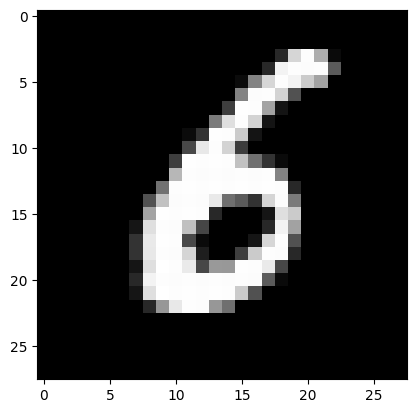

In [141]:
plt.imshow(x1[0], cmap="gray")
plt.show()

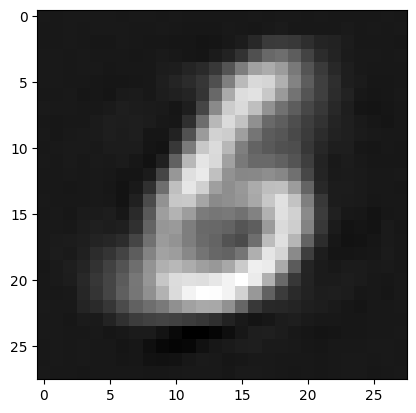

In [142]:
import matplotlib.pyplot as plt
plt.imshow(x2[0], cmap="gray")
plt.show()

In [144]:
std = torch.exp(0.5 * log)
z = torch.randn_like(std)
z = z * std + mu

In [145]:
z.shape

torch.Size([64, 2])

In [146]:
y.numpy()

array([6, 1, 6, 7, 2, 4, 4, 9, 5, 3, 2, 3, 5, 9, 2, 5, 0, 2, 0, 7, 6, 0,
       6, 4, 2, 3, 9, 9, 4, 8, 0, 5, 3, 4, 9, 9, 3, 1, 9, 9, 2, 6, 3, 4,
       9, 2, 3, 0, 0, 2, 6, 3, 5, 4, 4, 6, 4, 2, 0, 5, 2, 3, 1, 6],
      dtype=int64)

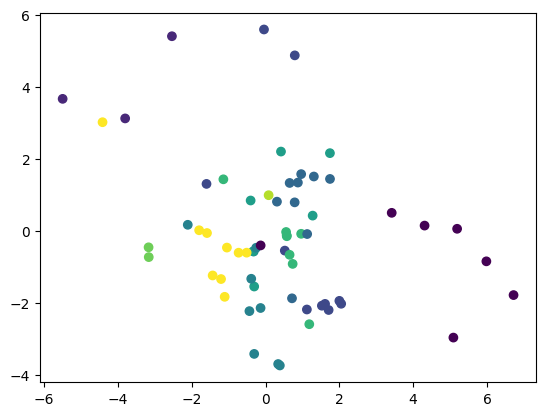

In [147]:
zx = z.detach().cpu()[:, 0]
zy = z.detach().cpu()[:, 1]


plt.scatter(zx, zy, c=y.numpy())